# Short introduction to particle physics

Modern particle physics research is focused on subatomic particles, including atomic constituents such as electrons, protons, and neutrons (protons and neutrons are composite particles called **baryons**, made of **quarks**), produced by radioactive and scattering processes, such as photons, neutrinos, and muons, as well as a wide range of exotic particles. All particles and their interactions observed to date can be described almost entirely by a quantum field theory called the Standard Model. The Standard Model, as currently formulated, has 61 elementary particles as summarised in the following figure:

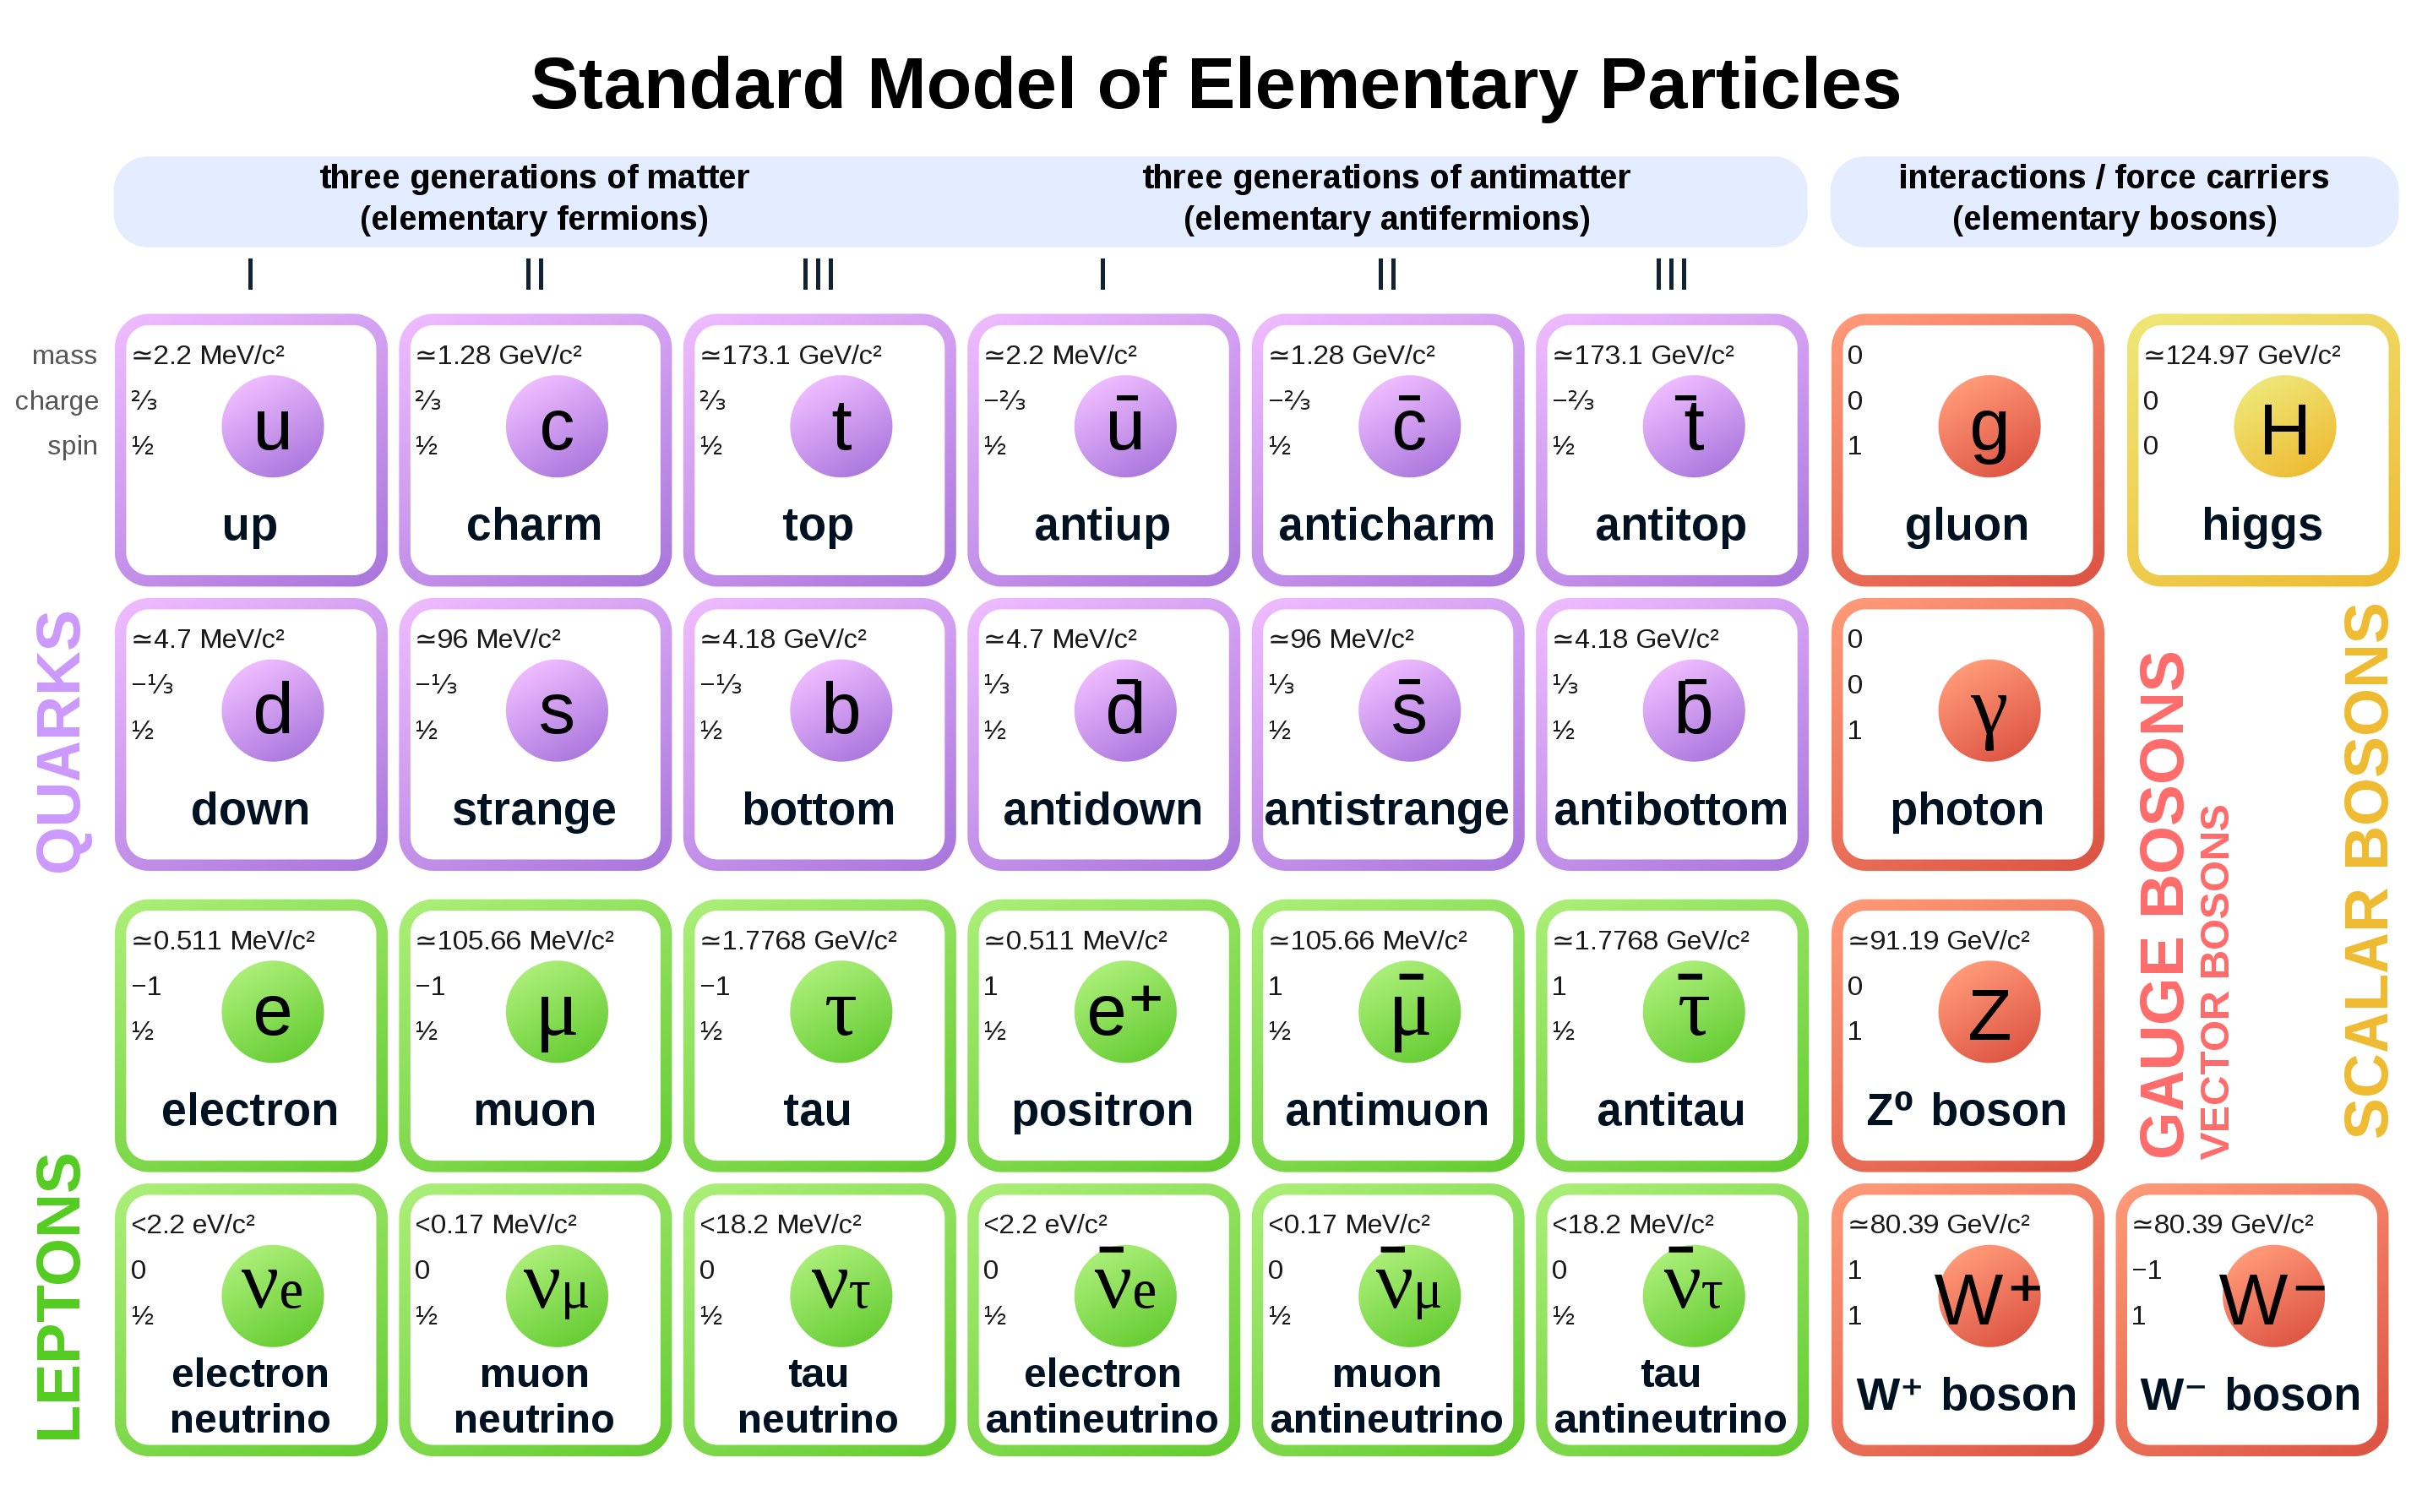

In [1]:
from IPython.display import Image
Image(filename='2880px-Standard_Model_of_Elementary_Particles_Anti.svg.png')#Source: By Cush - Own work, Public Domain, https://commons.wikimedia.org/w/index.php?curid=73606545

Those elementary particles can combine to form composite particles, accounting for the hundreds of other species of particles that have been discovered since the 1960s. Theoretical particle physics attempts to develop the models, theoretical framework, and mathematical tools to understand current experiments and make predictions for future experiments. There are several major interrelated efforts being made in theoretical particle physics today.

On top of elementary particles, the Standard Model explains the presence of **hadrons**. In particle physics, a hadron is a subatomic composite particle made of two or more quarks held together by the strong force in a similar way as molecules are held together by the electromagnetic force. Hadrons are categorised into two families: **baryons**, made of an odd number of quarks – usually three quarks – and **mesons**, made of an even number of quarks – usually one quark and one anti-quark. Protons and neutrons are examples of baryons; pions are an example of a meson. In fact, most of the mass of ordinary matter comes from two hadrons: the proton and the neutron. 

Not only does the Standard Model explain the formation of composite particles, but it also provides an organisational structure known as the so-called **eightfold way**. Indeed, because hadrons are comprised of a rather restrictive set of fundamental particles, they can be grouped together into multiplets. For instance, one finds a so-called *meson octet* which looks as follows:

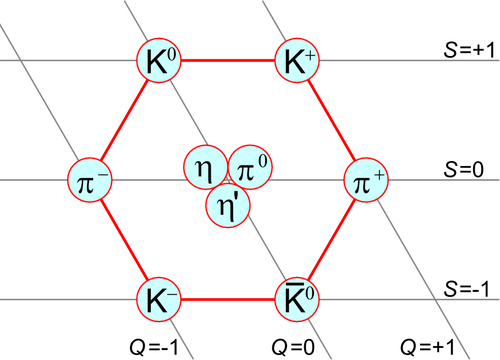

In [2]:
Image(filename='Noneto_mesônico_de_spin_0_res.png')#Source: Public Domain, https://commons.wikimedia.org/w/index.php?curid=510295

All of these particles are of similar mass which we show explicitly further below. For baryons, one finds an even more intricate structure, namely the *baryon decuplet*:

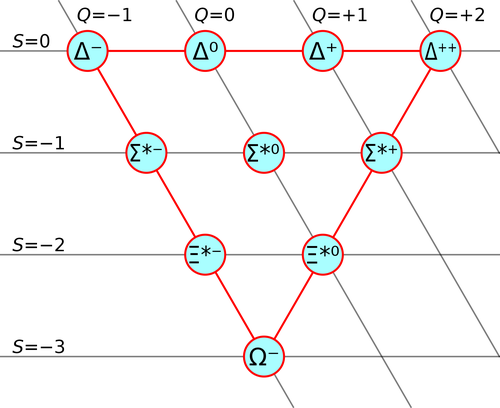

In [3]:
Image(filename='Baryon_decuplet.svg_res.png')#Source: By Wierdw123 at English Wikipedia(Original text: Wierdw123 (talk)) - Own work (Original text: self-made), Public Domain, https://commons.wikimedia.org/w/index.php?curid=3980451

The numbers *S* and *Q* are two quantum numbers specifying the particles. Furthermore, all the particles in the above diagram have nearly the same mass. The highly symmetric structure of this lattice can be explained from a group theoretical perspective, which is beyond the scope of this notebook.

Almost all "free" hadrons and antihadrons (meaning, in isolation and not bound within an atomic nucleus) are believed to be unstable and eventually decay (break down) into other particles. The only known exception relates to free protons, which are possibly stable, or at least, take immense amounts of time to decay. Experimentally, hadron physics is studied by colliding protons or nuclei of heavy elements such as lead or gold, and detecting the debris in the produced particle showers. In the natural environment, mesons such as pions are produced by the collisions of cosmic rays with the atmosphere. These decays have to follow certain **conservation laws** with the simplest being charge or energy conservation. That is, a particle of charge +1 can only decay into particles whose total charge is again +1. 

### Project description

This project aims at constructing models that learn the concepts of conservation laws as well as of multiplet structures. Such a model should be able to make predictions about future particle discoveries. Our idea is heavily inspired by the reconstruction of the periodic table from unsupervised learning in https://arxiv.org/pdf/1912.10708v1.pdf. In this sense, the aim of our project could be reformulated as **constructing the periodic table of particle physics**. Stated differently:

**What particle physicists took almost 100 years, we aim at doing in one notebook!**

In this notebook, we are working with essentially two datasets:
1. **mass_width_2020.csv**: An exhaustive list of experimentally observed particles with their physical properties such as mass, electric charge etc.
2. **DECAY_LHCB.DEC**: A file provided by a particle collider experiment at the LHC listing decays of particles and their likelihood.

We beging with analysing the data for particles contained in the first file. Later, we combine the data of the two files in a systematic manner in order to address a simple classification problem for particle decays.

**Disclaimer**: This notebook is still work in progress. We provide preliminary results for possible applications of machine learning techniques to a dataset consisting of Standard Model particles. But much remains to be done...

This project is a collaboration with Challenger Mishra (CST), Francesco Muia (DAMTP) and Fernando Quevedo (DAMTP).

# Particle data confirmed in experiments

First, let us import some packages which will be used throughout this notebook:

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='deep')

import decaylanguage
from decaylanguage import DecFileParser
from decaylanguage.dec import known_decay_models
from decaylanguage import DecayChainViewer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import pathlib
import seaborn as sns
import math
import random
import scipy

import sklearn
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
import sklearn.datasets
import sklearn.model_selection
import sklearn.pipeline
import sklearn.linear_model
import sklearn.ensemble
import sklearn.compose

import re
import warnings
warnings.filterwarnings('ignore')

from decimal import Decimal

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

from bokeh.plotting import Figure, output_notebook, show, save
from bokeh.models import ColumnDataSource, HoverTool, GroupFilter, CDSView

output_notebook()

Loading BokehJS ...

Let us begin by reading the datafiles. The file used here is obtained from https://github.com/scikit-hep/particle/tree/master/src/particle/data.

In [5]:
#Fix a date for the latest datafile
pick_a_date="2020"

#Read datafile into dataframe
df = pd.read_csv("mass_width_"+pick_a_date+".csv")

# get rid of blank spaces in column names
for i in range(len(df.keys())):
    key=str(df.keys()[i])
    key=key.replace(" ","")
    df=df.rename(columns={str(df.keys()[i]):str(key)})
    
#Replace all blank spaces in entries
df=df.replace(' ', '', regex=True)

#Drop some of the irrelevant columns
df=df.drop(['MassUpper', 'MassLower', 'WidthUpper','WidthLower',"Rank","Latex","Status"], axis=1)

df.head(10)

,ID,Mass,Width,I,G,P,C,Anti,Charge,Name,Quarks
0,1,4.67,-1.0,1/2,5,1,5,1,-1,d,d
1,-1,4.67,-1.0,1/2,5,1,5,1,1,d,D
2,2,2.16,-1.0,1/2,5,1,5,1,2,u,u
3,-2,2.16,-1.0,1/2,5,1,5,1,-2,u,U
4,3,93.00,-1.0,0,5,1,5,1,-1,s,s
5,-3,93.00,-1.0,0,5,1,5,1,1,s,S
6,4,1270.00,-1.0,0,5,1,5,1,2,c,c
7,-4,1270.00,-1.0,0,5,1,5,1,-2,c,C
8,5,4180.00,-1.0,0,5,1,5,1,-1,b,b
9,-5,4180.00,-1.0,0,5,1,5,1,1,b,B


The data describes properties of particle states. The columns have the following physical interpretation:

* **ID**: The ID specifies a particle through some integer number. The IDs of particle and anti-particle are related to each other via a simple sign flip.

* **Mass**: The Mass column quantifies the mass of particle in MeV.

* **Width**: The Width is related to the lifetime of a particle which will be computed further below.

* **I**: The isospin column **I** which relates certain quarks via linear transformations.

* **G**: G-parity is a quantum number associated with transformation properties of the particle states.

* **P**: P-parity describes the behaviour of a particle state under a space parity transformation.

* **C**: The column corresponds to charge conjugation properties of particles.

* **Anti**: It characterises the nature of anti-particles.

* **Charge**: Electric charge of particles.

* **Name**: Name of the particles.

* **Quarks**: Composition of the particle in terms of elementary constituents (quarks).

Let us get some info about the dataset:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      610 non-null    int64  
 1   Mass    610 non-null    float64
 2   Width   610 non-null    float64
 3   I       588 non-null    object 
 4   G       610 non-null    int64  
 5   P       610 non-null    int64  
 6   C       610 non-null    int64  
 7   Anti    610 non-null    int64  
 8   Charge  610 non-null    int64  
 9   Name    610 non-null    object 
 10  Quarks  538 non-null    object 
dtypes: float64(2), int64(6), object(3)
memory usage: 52.5+ KB


Obviously, this dataset is pretty small with only 610 data points. This highly restricts our model building approaches. Below we will show that this dataset can be expanded to about 5000 by including additional information from experiments. But more on that later in section "*Predicting Particle Decays*".

We notice that some parts of columns "*I*" and "*Quarks*" are NaNs simply because the two variables are not well-defined for the associated particles. We need to keep this in mind when we compute new features below.

Most importantly, we can use column *Quarks* below to distinguish between the different types of particles according to their composition in terms of quarks.

## Modification of the dataframe:

From the above data, we can generate some additional information about the individual particles. We are going to define the following functions to modify the dataframe:

1. **add_string**: Get number of elementary particles making up the composite particle

2. **get_isospin**: Get isospin

3. **get_isospin3**: Get 3rd component of isospin

4. **get_strangeness**: Get strangeness of a particle

5. **get_hypercharge**: Get hypercharge

6. **get_baryon_num**: Get baryon number

7. **get_typ**: Get the type of a particle (elementary, meson, baryon, unknown)

8. **change_name**: Change the names of the particles for later convenience (e.g. including info about the charge)

9. **treat_neutrinos_massless**: Replace the negative mass for neutrinos by exactly zero

10. **get_lepton_num**: Assign lepton number to particles

In [7]:
#add column
def add_string(row):
    
    name = row["Quarks"]
    
    
    if name!=name:#ignore NaNs
        return 0
    elif isinstance(name, str)==True:
        
        #get rid of constants etc. in linear combinations
        name=name.replace("/sqrt(2)","")
        name=name.replace("(","")
        name=name.replace(")","")
        name=name.replace("x","")
        name=name.replace("y","")
        name=name.replace("p","")
        name=name.replace("q","")
        if "+" in name:
            ind=name.index("+")
            name=name[:ind]
        elif "-" in name:
            ind=name.index("-")
            name=name[:ind]
    
        return len(name)
    else:
        return 0



def get_isospin(row):
    iso=row["I"]
    
    if iso=="?" or iso=="":
        return 0
    elif isinstance(iso, str)==True:
        iso=iso.replace("1/2","0.5")
        iso=iso.replace("3/2","1.5")
        return float(iso)
    else:
        return 0

def get_isospin3(row):
    iso=row["Quarks"]
    mass=row["Mass"]
    name=row["Name"]
    c=row["Charge"]
    
    if iso!=iso:#get rid of NaNs
        if mass<2000 and c!=0:#electrons, muons, tauons
            return np.sign(c)/2
        elif mass<0 and c==0:
            if "anti" in name:
                return -1/2
            else:
                return 1/2
        else:
            return 0
    else:
        nu=iso.count("u")
        nU=iso.count("U")
        nd=iso.count("d")
        nD=iso.count("D")
    
        return (nu-nU-(nd-nD))/2

def get_strangeness(row):
    s=row["Quarks"]
    if s!=s:
        return 0
    else:
        if "sqrt" in s:
            s=s.replace("sqrt","")
        ns=s.count("s")
        nS=s.count("S")
        return -ns+nS

def get_hypercharge(row):
    charge=row["Charge"]
    isospin=row["I3"]
    return 2*(charge-isospin)

def get_baryon_num(row):
    quarks=row["Quarks"]
    if quarks!=quarks or "Maybe" in quarks:# get rid of NaNs and unidentified particle content
        return 0
    else:
        quarks=quarks.replace("sqrt","")
        nq=len(re.findall('([a-z])', quarks))
        nQ=len(re.findall('([A-Z])', quarks))
        
        return (nq-nQ)/3

def get_typ(row):
    typ=row["Composition"]
    if typ<2:
        return "Elementary"
    elif typ==2:
        return "Meson"
    elif typ==3:
        return "Baryon"
    else:
        return "Unknown"
        
def change_name(row):
    name=row["Name"]
    charge=row["Charge"]
    
    if "nu" in name:
        pid=row["ID"]
        ind1=name.index("(")
        ind2=name.index(")")
        if pid<0:
            return "anti-nu_"+name[ind1+1:ind2]
        elif pid>0:
            return "nu_"+name[ind1+1:ind2]
    elif "gamma" in name or "eta" in name:
        return name
    elif charge==0:
        pid=row["ID"]
        if pid>0:
            return name+"0"
        elif pid<0:
            return "anti-"+name+"0"
    elif np.sign(charge)<0:
        return name+"-"
    elif np.sign(charge)>0:
        return name+"+"
    
def treat_neutrinos_massless(row):
    name=row["Name"]
    mass=row["Mass"]
    
    if "nu" in name:
        return 0
    else:
        return mass
    
    
def get_lepton_num(row):
    comp=row["Composition"]
    mass=row["Mass"]
    charge=row["Charge"]
    name=row["Name"]
    if comp>0:# get rid of NaNs
        return 0
    else:
        if mass<1800 and mass>0:
            return (-1)*np.sign(charge)
        elif mass>1800: #W+-,Z,H0
            return 0
        else:
            if "anti" in name:
                return -1
            elif "g" in name:#photon and gluons
                return 0
            else:
                return +1

In [8]:
df_cf=df.copy()

#Compute correctly normalised charges
df_cf["Charge"]=(df_cf["Charge"]/3).round(2)

#Compute the lifetime
df_cf["Lifetime"]=6.582119569*10**(-16)/(df_cf["Width"]*10**(6))
#Replace infinitities by 10^10 for now
df_cf=df_cf.replace([np.inf], 10**(10))
#Drop unnecessary column "Width"
df_cf=df_cf.drop(['Width'], axis=1)

#Change negative mass of neutrinos to 0
df_cf["Mass"] = df_cf[["Mass","Name"]].apply(treat_neutrinos_massless, axis=1)

#Modify the name column for later purposes
df_cf["Name"] = df_cf[["Name","Charge","ID"]].apply(change_name, axis=1)

#Get a numerical expression for the composition of particles from the "Quarks" column
df_cf["Composition"] = df_cf[["Quarks"]].apply(add_string, axis=1)

#Define the type of a particle from the "Composition" column
df_cf["Typ"] = df_cf[["Composition"]].apply(get_typ, axis=1)

#Define a new quantum number: isospin
df_cf["I"] = df_cf[["I"]].apply(get_isospin, axis=1)

#Define a new quantum number: 3rd component of isospin
df_cf["I3"] = df_cf[["Quarks","Mass","Name","Charge"]].apply(get_isospin3, axis=1)

#Define a new quantum number: baryon number
df_cf["B"] = df_cf[["Quarks"]].apply(get_baryon_num, axis=1)

#Define a new quantum number: lepton number
df_cf["L"] = df_cf[["Mass","Charge","Composition","Name"]].apply(get_lepton_num, axis=1)

#Define a new quantum number: strangeness
df_cf["S"] = df_cf[["Quarks"]].apply(get_strangeness, axis=1)

#Define a new quantum number: hypercharge
df_cf["Y"] = df_cf[["Charge","I3"]].apply(get_hypercharge, axis=1)

#Rename "ID" column
df_cf=df_cf.rename(columns={"ID":"Particle ID"})

#Reorder columns
cols=['Name','Typ','Mass','Charge','I','G','P','C','Anti','Quarks','Lifetime','I3','B','L','S','Y','Composition','Particle ID']
df_cf= df_cf[cols]

df_cf.head(10)

,Name,Typ,Mass,Charge,I,G,P,C,Anti,Quarks,Lifetime,I3,B,L,S,Y,Composition,Particle ID
0,d-,Elementary,4.67,-0.33,0.5,5,1,5,1,d,-6.582120e-22,-0.5,0.333333,0.0,0,0.34,1,1
1,d+,Elementary,4.67,0.33,0.5,5,1,5,1,D,-6.582120e-22,0.5,-0.333333,0.0,0,-0.34,1,-1
2,u+,Elementary,2.16,0.67,0.5,5,1,5,1,u,-6.582120e-22,0.5,0.333333,0.0,0,0.34,1,2
3,u-,Elementary,2.16,-0.67,0.5,5,1,5,1,U,-6.582120e-22,-0.5,-0.333333,0.0,0,-0.34,1,-2
4,s-,Elementary,93.00,-0.33,0.0,5,1,5,1,s,-6.582120e-22,0.0,0.333333,0.0,-1,-0.66,1,3
5,s+,Elementary,93.00,0.33,0.0,5,1,5,1,S,-6.582120e-22,0.0,-0.333333,0.0,1,0.66,1,-3
6,c+,Elementary,1270.00,0.67,0.0,5,1,5,1,c,-6.582120e-22,0.0,0.333333,0.0,0,1.34,1,4
7,c-,Elementary,1270.00,-0.67,0.0,5,1,5,1,C,-6.582120e-22,0.0,-0.333333,0.0,0,-1.34,1,-4
8,b-,Elementary,4180.00,-0.33,0.0,5,1,5,1,b,-6.582120e-22,0.0,0.333333,0.0,0,-0.66,1,5
9,b+,Elementary,4180.00,0.33,0.0,5,1,5,1,B,-6.582120e-22,0.0,-0.333333,0.0,0,0.66,1,-5


The modified dataframe is now ready to be analysed in more detail. The new column *Typ* allows us to distinguish between elementary and composite particles. Further information is gained from the *Lifetime* column: it is a measure for the likelihood for a particle to decay. 

For completeness, let us generate dataframes for the individual types of particles:

In [9]:
#Elementary particles
df_elem=df_cf.copy()
boslep=df_elem["Composition"]==0
quarks=df_elem["Composition"]==1
df_elem=df_elem[boslep | quarks]
print("We found ",len(df_elem)," elementary particles!")
df_elem.reset_index(inplace = True) 

#Baryons
df_baryons=df_cf.copy()
df_baryons=df_baryons[df_baryons["Composition"]==3]
print("We found ",len(df_baryons)," baryons!")
df_baryons.reset_index(inplace = True) 

#Mesons
df_mesons=df_cf.copy()
df_mesons=df_mesons[df_mesons["Composition"]==2]
print("We found ",len(df_mesons)," mesons!")
df_mesons.reset_index(inplace = True) 

We found  84  elementary particles!
We found  292  baryons!
We found  222  mesons!


# Qualitative data analysis

At this stage, it is worth exploring the data together with its correlations and symmetries. We begin by looking at the distribution of (a subset of) values in the various columns of our dataframe:

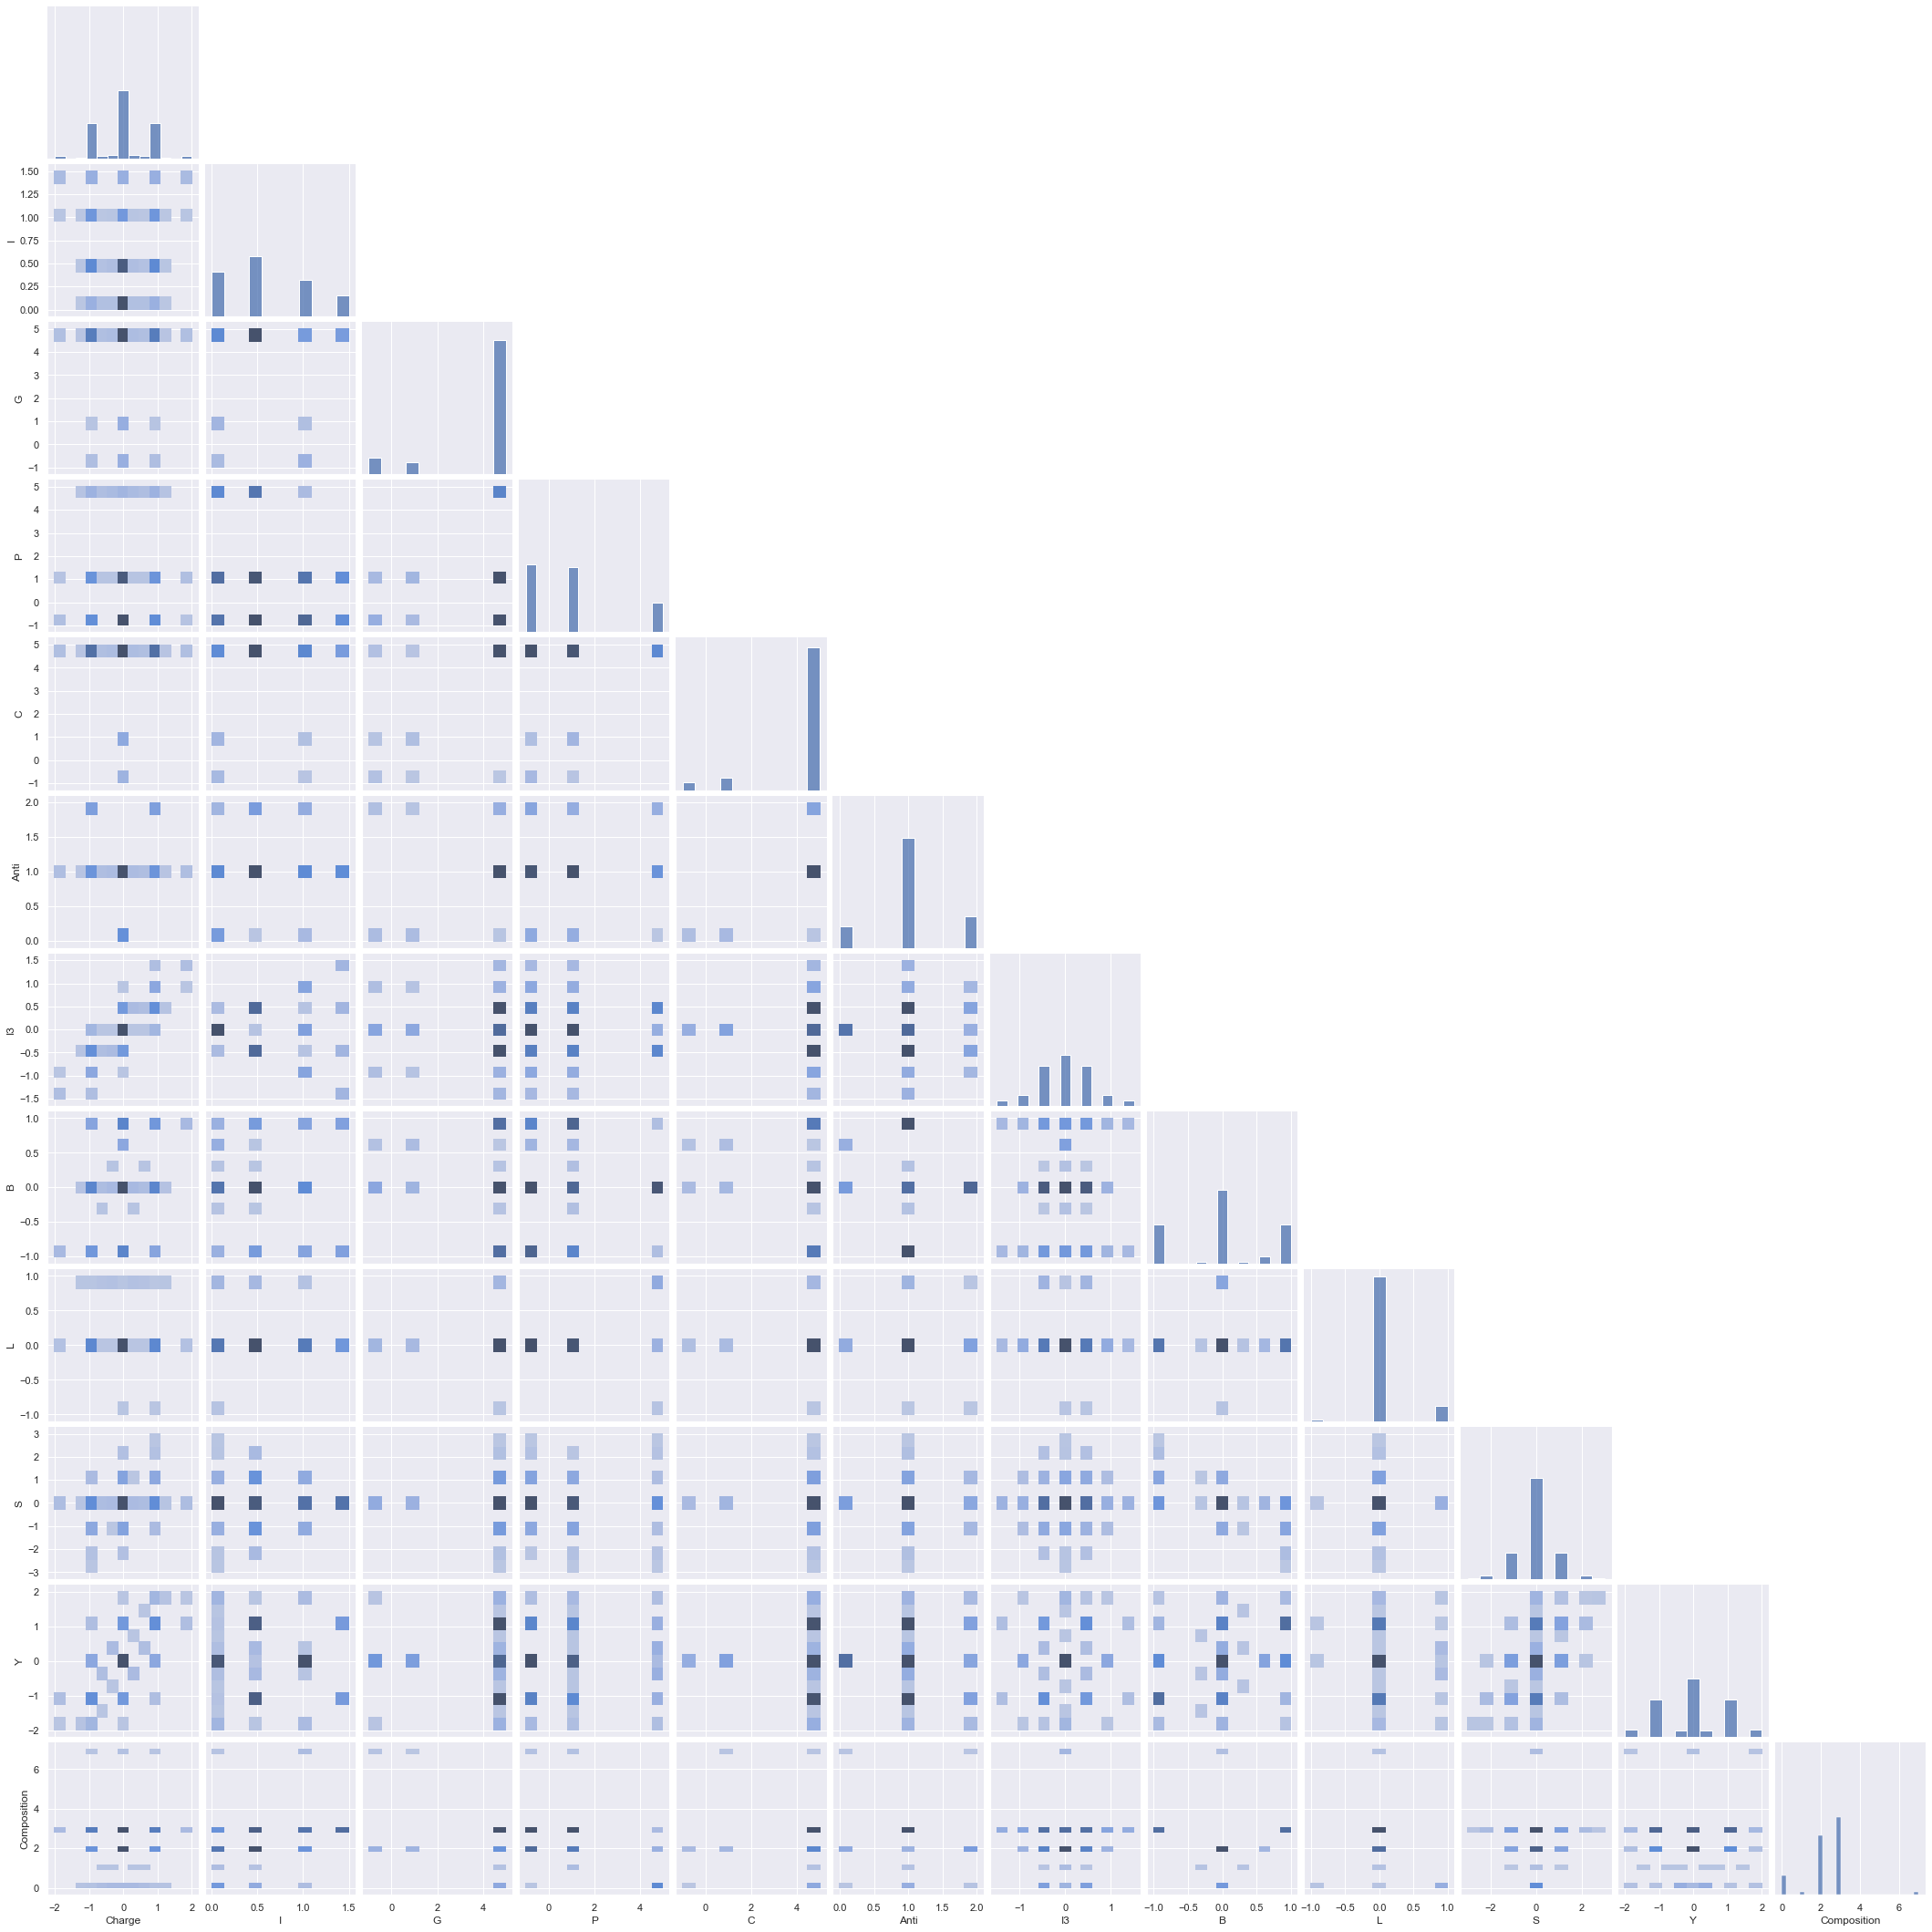

In [10]:
df_sns=df_cf.copy()
df_sns=df_sns.drop(['Lifetime',"Typ","Particle ID","Name","Quarks","Mass"], axis=1)
sns.pairplot(data=df_sns,corner=True,kind="hist",diag_kind="hist",);

We notice that there are certain lattice structures for most of the entries. This is related to the nature of *quantum numbers*: they are *quantised* in the sense that they only come in portions of fixed integral size.

To get a better understanding of the data, let us look at the density plots:

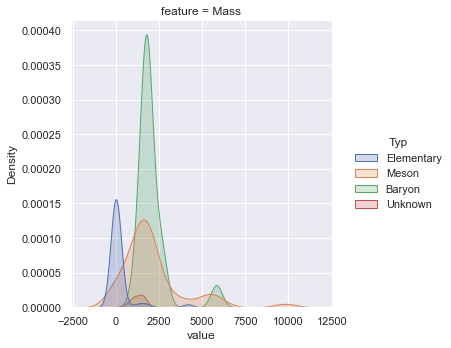

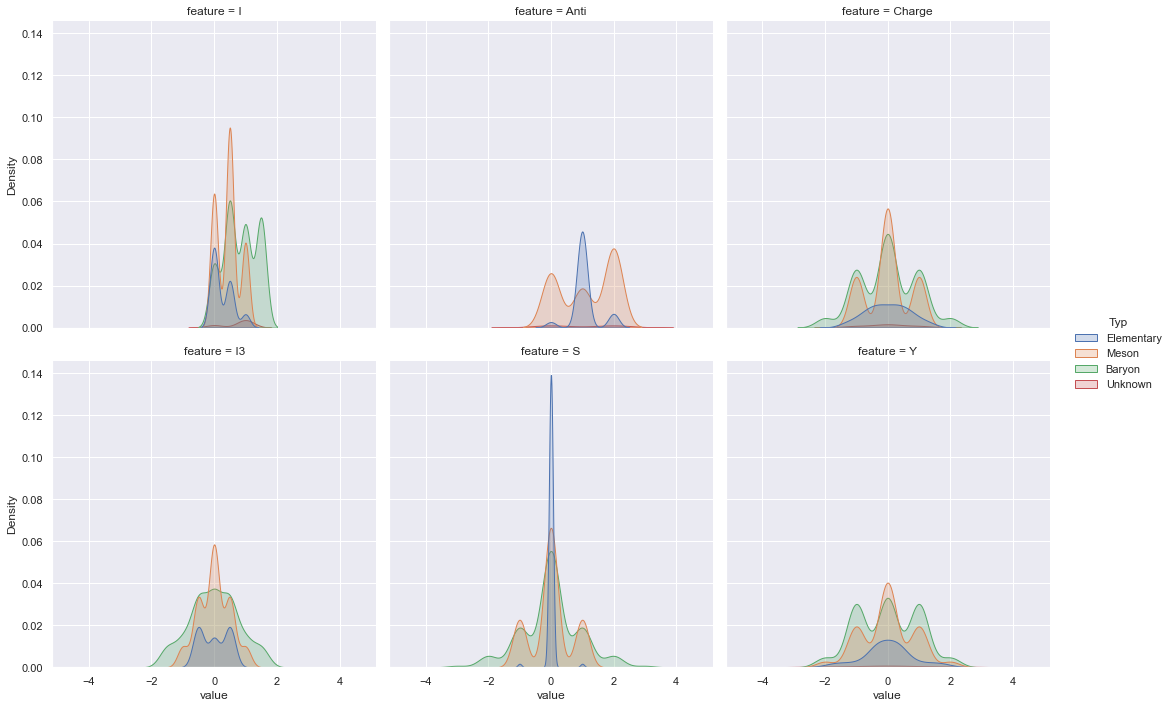

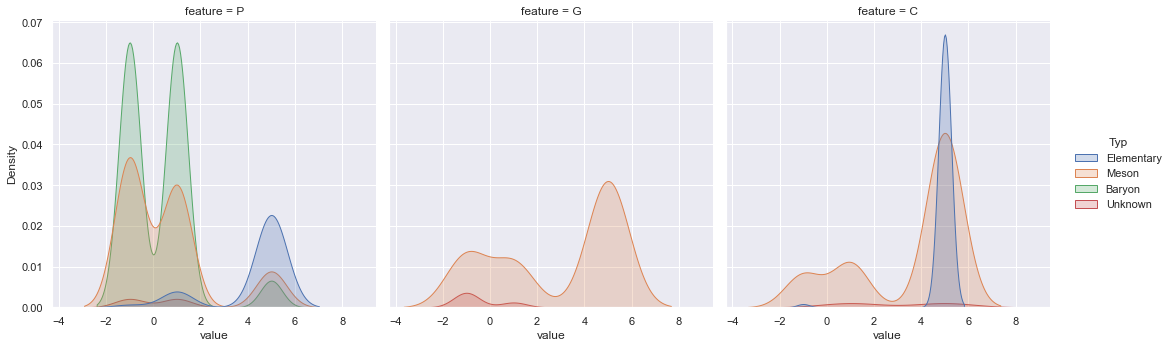

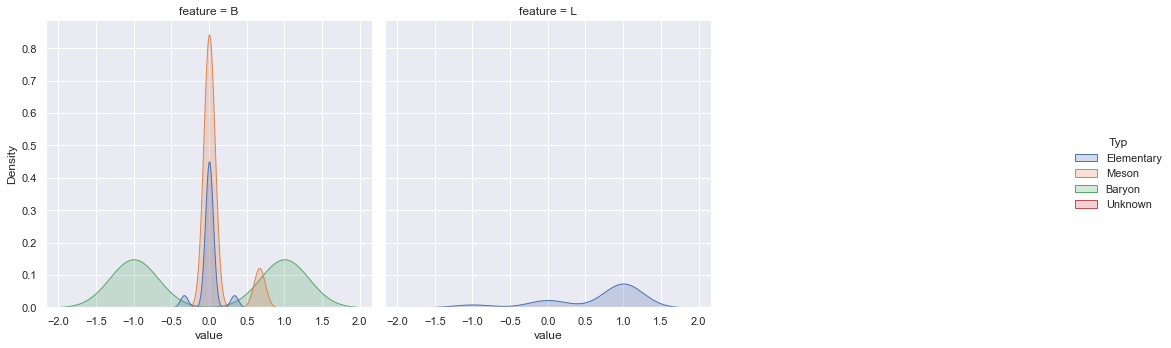

In [11]:
#Remove outliers in the mass column
df_mdensity=df_cf.copy()
df_mdensity=df_mdensity[df_mdensity["Mass"]<10000]#get rid of outlier in mass parameter
data_mass= df_mdensity.melt(value_vars=["Mass"], id_vars='Typ', var_name='feature', value_name='value')

#Construct subsets of the initial dataframes that should be plotted on the same scales
data_QN = df_cf.melt(value_vars=['I','Anti','Charge','I3','S','Y'], id_vars='Typ', var_name='feature', value_name='value')
data_parities = df_cf.melt(value_vars=['P','G','C'], id_vars='Typ', var_name='feature', value_name='value')
data_lbn= df_cf.melt(value_vars=['B','L'], id_vars='Typ', var_name='feature', value_name='value')

#Mass plot
sns.displot(data=data_mass,  hue='Typ', x='value', kind='kde', col='feature', col_wrap=1, fill=True);

#Plot quantum numbers
sns.displot(data=data_QN,  hue='Typ', x='value', kind='kde', col='feature', col_wrap=3, fill=True);

#Plot for parity properties
sns.displot(data=data_parities,  hue='Typ', x='value', kind='kde', col='feature', col_wrap=3, fill=True);

#Plot for lepton and baryon number
sns.displot(data=data_lbn,  hue='Typ', x='value', kind='kde', col='feature', col_wrap=3, fill=True);

The first plot for the mass density proves that there are certain high density regions, but also voids. Both clearly depend on the type of the particle. The 6 plots in the middle are (mostly) highly symmetric. In contrast, the 3 plots in the second to last line are non-symmetric in the type of particle. Finally, the last 2 plots show baryon and lepton quantum numbers which are e.g. handy to distinguish different types of particles.

A further interesting question concerns the nature of correlations in the dataset. They can also be analysed with the help of the following plot:

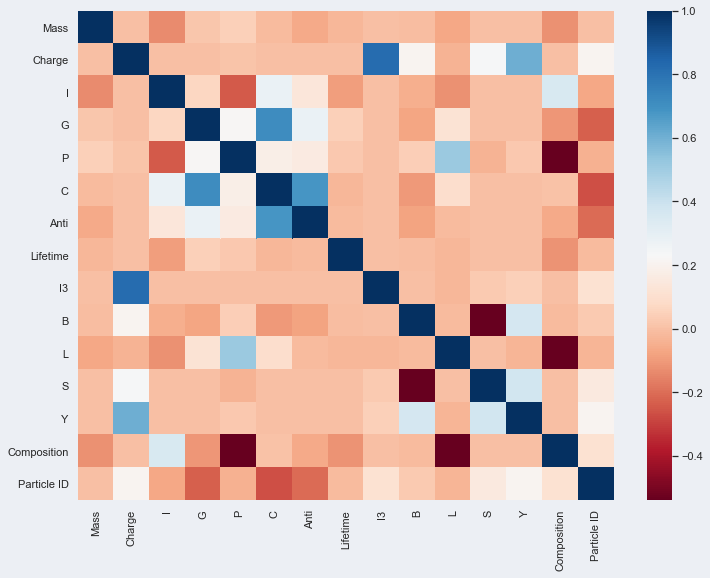

In [12]:
correlations=df_cf.corr()
plt.figure(figsize=(12,9),facecolor="#ECEFF4");
sns.heatmap(correlations,cmap="RdBu");

There are some strong (anti-)correlations between several of the columns in the dataframe. This is simply because some of them had been derived from only a subset of columns in the original datafile.

Finally, let us have a closer look at the mass-charge plane via Bokeh distinguishing between the different types of particles:

In [13]:
from bokeh.resources import CDN
from bokeh.embed import file_html

df_bk=df_cf.copy()
df_bk=df_bk[df_bk["Mass"]>0] #some particles have unknown mass which have negative mass in the dataframe
df_bk["Mass"]=np.log10(df_bk["Mass"])

#Make a dictonary with COLORS using keys from "Typ" in dataframe
type_colors = {'Meson':'#CE1141', 'Baryon': 'orange', 'Elementary': 'blue', 'Unknown': 'green'}

df_bk['color_column'] = df_bk['Typ'].map(type_colors)

data = ColumnDataSource(df_bk)
plot_MN = Figure(title="Mass vs. charge for experimentally confirmed particle data",tools='', tooltips=[('Name', '@Name'), ('Composition', '@Quarks')], width=600, height=600)
plot_MN.title.align = "center"
plot_MN.title.text_font_size = "20px"
plot_MN.scatter(source=data,x='Mass', y='Charge', \
                   fill_color='color_column', size=10, \
                  legend_group='Typ')
plot_MN.xaxis.axis_label,plot_MN.yaxis.axis_label  = ('Log10(Mass)', 'Charge')

show(plot_MN)

save(plot_MN, filename='MC.html', resources='inline', title="Mass vs. charge for experimentally confirmed particle data");

The information contained in this plot can be summarised as follows:

1. First and foremost, there is a clear symmetry visible between the bottom and the upper half of the figure. It is referred to **particle/anti-particle symmetry** or **charge conjugation symmetry** which means that to every particle of mass *M* and charge *Q* there exists a corresponding *anti*-particle of the same mass *M* and of opposite charge *-Q*.

2. Clearly, only a few (elementary) particles have fractional charges corresponding to quarks. These are the building blocks for the meson (red) and baryon (yellow) particles in the above plot.

3. There seem to be certain clusters of particles that can potentially be grouped together. This becomes even more apparent when focussing into the mass range of $2.1<\log_{10}(\text{mass})<4.2$:

In [14]:
#Restrict data to a particular mass range
df_bk=df_bk[df_bk["Mass"]>2.1]
df_bk=df_bk[df_bk["Mass"]<4.2]
data = ColumnDataSource(df_bk)
plot_MN = Figure(title="Mass vs. charge for restricted particle data",tools='', tooltips=[('Name', '@Name'), ('Composition', '@Quarks')], width=600, height=600)
plot_MN.title.align = "center"
plot_MN.title.text_font_size = "20px"
plot_MN.scatter(source=data,x='Mass', y='Charge', \
                   fill_color='color_column', size=10, \
                  legend_group='Typ')
plot_MN.xaxis.axis_label,plot_MN.yaxis.axis_label  = ('Log10(Mass)', 'Charge')

show(plot_MN)

This observation played a big role in uncovering the hidden structure of this dataset. In fact, it is directly related to our initial comments about the so-called *eightfold way* and multiplets of particles.

To make this point clear, we look at the meson dataframe *df_mesons*. By restricting the mass to the smallest non-vanishing values, we find the following plot in the *(S,I3)* plane:

In [15]:
df_mesons_eightfold=df_mesons.copy()
df_mesons_eightfold=df_mesons_eightfold[df_mesons_eightfold["Mass"]<500]
df_mesons_eightfold=df_mesons_eightfold[df_mesons_eightfold["Mass"]>0]
print("Length of dataframe: ",len(df_mesons_eightfold))

data = ColumnDataSource(df_mesons_eightfold)
plot_MO = Figure(title="Lightest meson configuration",tools='', tooltips=[('Name', '@Name'), ('Composition', '@Quarks'), ('Mass', '@Mass')], width=500, height=500)
plot_MO.title.align = "center"
plot_MO.title.text_font_size = "20px"
plot_MO.scatter(source=data,x='I3', y='S', size=10)
plot_MO.xaxis.axis_label,plot_MO.yaxis.axis_label  = ('I3', 'S')

show(plot_MO)
save(plot_MO, filename='OCM.html', resources='inline', title="Lightest meson configuration");

Length of dataframe:  9


Notice that although the dataframe involves 9 items, there are only 7 points visible in the above plots. This is because the origin actually consists of 3 separate data points. We encountered this exact configuration of particles at the beginning of this notebook, namely

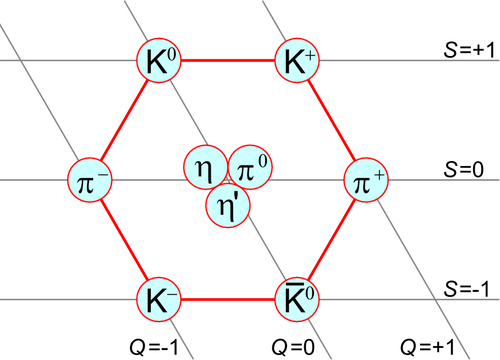

In [16]:
Image(filename='Noneto_mesônico_de_spin_0_res.png')#Source: Public Domain, https://commons.wikimedia.org/w/index.php?curid=510295

This and many analogous constructions can be understood from the mathematical concept of representation theory of so-called **Lie groups**. In our above dataset, there are several of these configurations hidden. The most important ones are:

In [17]:
#weight_systems:
triplet = np.array([[1,0],[-1,0],[0,-2]])/2
sextuplet = np.array([[2,-2],[0,2],[1,0],[0,-2],[-1,0],[-2,-2]])/2
octuplet = np.array([[1,2],[-1,2],[2,0],[0,0],[0,0],[-2,0],[1,-2],[-1,-2]])/2
decuplet =np.array([[0,6],[-1,4],[1,4],[-2,2],[0,2],[2,2],[-3,0],[-1,0],[1,0],[3,0]])/2
quintuplet = np.array([[-2,2],[0,2],[2,2],[-3,0],[-1,0],[1,0],[3,0],[-2,-2],[0,-2],[2,-2],[-1,-4],[1,-4]])/2

df_t=pd.DataFrame(triplet)
df_t["Type"]="Triplet"
df_t=df_t.rename(columns={0:"I3",1:"S"})
df_s=pd.DataFrame(sextuplet)
df_s["Type"]="Sextuplet"
df_s=df_s.rename(columns={0:"I3",1:"S"})
df_o=pd.DataFrame(octuplet)
df_o["Type"]="Octuplet"
df_o=df_o.rename(columns={0:"I3",1:"S"})
df_d=pd.DataFrame(decuplet)
df_d["Type"]="Decuplet"
df_d=df_d.rename(columns={0:"I3",1:"S"})
df_q=pd.DataFrame(quintuplet)
df_q["Type"]="Quintuplet"
df_q=df_q.rename(columns={0:"I3",1:"S"})
frames=[df_t,df_s,df_o,df_d,df_q]

for frame in frames:
    data = ColumnDataSource(frame)
    title_name=frame["Type"][0]
    plot_MO = Figure(title=title_name,width=400, height=400)
    plot_MO.title.align = "center"
    plot_MO.title.text_font_size = "14px"
    plot_MO.scatter(source=data,x='I3', y='S', size=10)
    plot_MO.xaxis.axis_label,plot_MO.yaxis.axis_label  = ('I3', 'S')
    show(plot_MO)
    save(plot_MO, filename=title_name+'.html', resources='inline', title=title_name);

All of these individual structures appear in the dataframe lying on top of each other:

In [18]:
df_mutliplets=pd.concat(frames)

#Make a dictonary with COLORS using keys from "Typ" in dataframe
type_colors = {'Triplet':'#CE1141', 'Sextuplet': 'orange', 'Octuplet': 'blue', 'Decuplet': 'green', 'Quintuplet': 'black'}

df_mutliplets['color_column'] = df_mutliplets['Type'].map(type_colors)

data = ColumnDataSource(df_mutliplets)
plot_MP = Figure(title="Combined multiplet configurations",tools='', tooltips=[('Multiplet', '@Type')], width=500, height=500)
plot_MP.title.align = "center"
plot_MP.title.text_font_size = "20px"
plot_MP.scatter(source=data,x='I3', y='S',fill_color='color_column', size=10,legend_group='Type')
plot_MP.xaxis.axis_label,plot_MP.yaxis.axis_label  = ('I3', 'S')

show(plot_MP)
save(plot_MP, filename='CMC.html', resources='inline', title="Combined multiplet configurations");

Ultimately, we are interested in classifying all of these multiplet configurations. However, the data given in *df_cf* is insufficient for a model to find these hidden structure without given it too much external input.

This is why we
1. search for additional data and
2. try to learn simpler concepts like conservation of energy and charge.

In this way, we hope to build a model from the bottom up that is able to make theoretical predictions for particle observations from experimental signatures.

# Predicting Particle Decays

What we actually measure at experiments are collisions and the subsequent decays of particles. Here we use the python package https://github.com/scikit-hep/decaylanguage to study to handle the available data.

Let us first read the datafile:

In [19]:
#Read datafile
parser = DecFileParser('DECAY_LHCB.DEC')
parser.parse()

# Inspect what decays are defined
decays_tot=parser.list_decay_mother_names()

print(f"We found a total of {len(decays_tot)} decays in our dataset!")

We found a total of 506 decays in our dataset!


The list *decays_tot* contains all decays of particles as measured by the LHCb experiments. For example, a single decay for a particle called **tau+** looks as follows

In [20]:
decay=list(parser.list_decay_modes('tau+'))
decay

[['e+', 'nu_e', 'anti-nu_tau'],
 ['mu+', 'nu_mu', 'anti-nu_tau'],
 ['pi+', 'anti-nu_tau'],
 ['K+', 'anti-nu_tau'],
 ['pi+', 'pi0', 'anti-nu_tau'],
 ['anti-nu_tau', 'gamma', 'pi+', 'pi0'],
 ['pi0', 'pi0', 'pi+', 'anti-nu_tau'],
 ['anti-nu_tau', 'K+', 'pi0', 'pi0'],
 ['anti-nu_tau', 'pi+', 'pi0', 'pi0', 'pi0'],
 ['anti-nu_tau', 'pi+', 'pi0', 'pi0', 'pi0', 'pi0'],
 ['anti-nu_tau', 'pi+', 'K0'],
 ['anti-nu_tau', 'K+', 'anti-K0'],
 ['anti-nu_tau', 'anti-K0', 'pi+', 'K0'],
 ['anti-nu_tau', 'K+', 'pi0', 'anti-K0'],
 ['anti-nu_tau', 'pi+', 'K0', 'pi0'],
 ['pi+', 'pi+', 'pi-', 'anti-nu_tau'],
 ['anti-nu_tau', 'pi+', 'pi-', 'pi+', 'pi0'],
 ['anti-nu_tau', 'pi+', 'pi+', 'pi-', 'pi0', 'pi0'],
 ['anti-nu_tau', 'pi+', 'pi+', 'pi-', 'pi0', 'pi0', 'pi0'],
 ['anti-nu_tau', 'K+', 'pi-', 'pi+'],
 ['anti-nu_tau', 'K+', 'pi-', 'pi+', 'pi0'],
 ['anti-nu_tau', 'K+', 'pi+', 'K-'],
 ['anti-nu_tau', 'K+', 'K-', 'K+'],
 ['anti-nu_tau', 'pi+', 'pi+', 'pi+', 'pi-', 'pi-'],
 ['anti-nu_tau', 'pi+', 'pi+', 'pi+', 'pi

That is, it corresponds to a list of so called **decay channels** characterising the different decay processes for a single particle. Notice that the number of particles after the decay varies depending on the decay channel. Associated with decays are a number of conservation laws such as charge and energy conservation.

Our first strategy is to learn what "physical" decays look like. To do so, we replace for every decay of the form

$[\tau_+] \rightarrow [e_+, \nu_e, \bar{\nu}_{\tau}]$

the strings by the data

$[mass(\tau_+),charge(\tau_+)] \rightarrow [mass(e_+),charge(e_+),mass(\nu_e),charge(\nu_e),mass(\bar{\nu}_{\tau}),charge(\bar{\nu}_{\tau})]$

restricting to only mass and charge as input features for the moment.
Subsequently, we formulate a classification problem by replacing the decay data

$[p_1] \rightarrow [p_2,p_3,...,p_N]$

by an input vectors of the form

$[mass(p_1),charge(p_1),mass(p_2),charge(p_2),...,mass(p_N),charge(p_N),0,0,...,0]$

where we might have to supplement the data by zeros to have a fixed, constant input size. (Recall that the number of particles after a decay is non-constant.) For the example of the "tau+" decay, we would have

$[mass(\tau_+),charge(\tau_+),mass(e_+),charge(e_+),mass(\nu_e),charge(\nu_e),mass(\bar{\nu}_{\tau}),charge(\bar{\nu}_{\tau}),0,0,...,0]$

For a binary classification problem, we assign output labels $[0,1]$ depending on whether a decay is (1) or is not (0) allowed by physical principles.

In what follows, we consider 4 input features:
* mass
* charge
* isospin $I$
* 3rd component of isospin $I_3$

To get started, we define the following objects:

In [21]:
#Features in our dataframe that we would like to drop
column_drop=["Particle ID","Quarks","Name","Typ","G","P","C","B","L","S","Y","Lifetime","Anti","Composition"]#Including I and I3

#Names of particles in our dataframe
particle_names=df_cf["Name"].to_list()

#Number of input features corresponding to #cols in df_cf minus length of column_drop:
num_features=len(df_cf.columns.to_list())-len(column_drop)

Then we generate the data as described above. This is achieved by first translating the above data in terms of strings encoded in *DECAY_LHCB.DEC* into lists of the form

$[[p_1],[[p_2],...,[p_N]]]$

or more explicitly

$[[mass(p_1),charge(p_1),I(p_1),I_3(p_1)],[[mass(p_2),charge(p_2),I(p_2),I_3(p_2)],...,[mass(p_N),charge(p_N),I(p_N),I_3(p_N)]]]$.

In [22]:
#Get particle with "Name"==name_str from original dataframe df_cf
def get_particle(name_str):
    df_p4=df_cf.copy()
    df_p4=df_p4[df_p4["Name"]==name_str]
    return df_p4

#Find suitable particle with given name particle in the list particle_names corresponding 
#to the names appearing in the original dataframe df_cf
def find_suitable_particle(particle,particle_names):
    
    if "+" in particle:
        key="+"
        ind=particle.index("+")
    elif "-" in particle:
        key="-"
        ind=particle.index("-")
    elif "0" in particle:
        key="0"
        ind=particle.index("0")
    else:
        key=""
        ind=len(particle)
        
    particle_name=particle[:ind]
                
    if "_" in particle_name:
        ind=particle_name.index("_")
        particle_name=particle_name[:ind]+"("+particle_name[ind+1:]+")"
                    
    df_p3=[]
    
    for possible_name in particle_names:
        if particle_name in possible_name and key in possible_name:
            if key!="-":
                if key=="0":#There can be names which have additional zeros as IDs
                    #test if ending of string is 0
                    if possible_name[-1]=="0":
                        df_p3=get_particle(possible_name)
                                    
                        break
                                
                elif "++" in particle:#Some particles have charge>1
                    df_p2=get_particle(possible_name)
                    ind_c=df_p2.columns.to_list().index("Charge")
                    if df_p2.iloc[0].to_list()[ind_c]>1:
                        df_p3=get_particle(possible_name)
                        break
                                    
                                
                else:
                    df_p3=get_particle(possible_name)
                                
                    break
            elif key=="-":
                if "anti" not in possible_name:
                    df_p3=get_particle(possible_name)
                    
                    break
                    
                elif "anti" in possible_name and possible_name[-1]==key:
                    df_p3=get_particle(possible_name)
                    
                    break
                             
    return df_p3,possible_name




#Get real decays
pdata_decays=[]

#Counter for decays which we were not able to identify
count_wrong_decay=0

#Counter for the number of confirmed decays
count_known_decay=0

#List of particles for which there is a known decay
particles_known_decays=[]

#List of particles for which there is NO known decay
particles_no_decays=[]

#List of particles which appear in the endproduct of a known decay
particles_known_endproduct=[]

#List of particles which DO NOT appear in the endproduct of a known decay
particles_no_endproduct=[]

#Counts the maximal number of particles after a successful decay
max_end=0

#Loop over all particle names in the decay file corresponding to initial particles in a decay
for name in decays_tot:
    
    #Get all the decays for the particle with "Name"==name
    decays=list(parser.list_decay_modes(name))
    df_p=df_cf.copy()
    df_p=df_p[df_p["Name"]==name]
    
    #If the name does not have an exact match in dataframe, look for alias
    if len(df_p)<1:
        df_p,name_plist=find_suitable_particle(name,particle_names)
        if len(df_p)<1:
            #print("DIDN'T FIND INITIAL PARTICLE: ",name)
            particles_no_decays.append(name)
        else:
            particles_known_decays.append(name_plist)
            count_known_decay+=1
    else:
        particles_known_decays.append(name)
        count_known_decay+=1
    #Continue only if particle found
    if len(df_p)>0:
        ln_in=df_p["L"].to_list()[0]
        bn_in=df_p["B"].to_list()[0]
        df_p=df_p.drop(column_drop,axis=1)
        
        for decay in decays:
        
            #go through particles in decay and get data
            decay_data=[]
            #to check later whether all particles have been found
            dgood=1
            ln_fin=[]
            bn_fin=[]
            
            if len(decay)<1:
                dgood=-1
            
            #Loop over all particles in decay
            for particle in decay:
                
                df_p1=df_cf.copy()
                df_p1=df_p1[df_p1["Name"]==particle]
                
                #If the name does not have an exact match in dataframe, look for alias
                if len(df_p1)<1:
                    df_p1,name_plist=find_suitable_particle(particle,particle_names)
                    if len(df_p1)>0:
                        particles_known_endproduct.append(name_plist)
                        
                else:
                    particles_known_endproduct.append(particle)
                    
                if len(df_p1)>0:
                    df_p1=df_p1.drop(column_drop,axis=1)
                    pdata=df_p1.iloc[0].to_list()
                    decay_data.append(pdata)
                else:
                    dgood=-1
                    particles_no_endproduct.append(particle)
                    break
            if dgood>0:
                pdata=df_p.iloc[0].to_list()
            
                #filter out those decays violating energy conservation
                decay_test=[pdata,decay_data]
                num_end=len(decay_data)
                if num_end>max_end:
                    max_end=num_end
                   
                mass=decay_test[0][0]
                charge=decay_test[0][1]
                summass=0
                totcharge=0
                for p in decay_test[1]:
                    summass+=p[0]
                    totcharge+=p[1]
                
                #Test if energy is conserved
                if summass>mass:
                    count_wrong_decay+=1
                #Test if charge is conserved
                elif totcharge!=charge:
                    count_wrong_decay+=1
                #If both charge and energy are conserved, append decay to pdata_decays
                else:
                    pdata_decays.append(decay_test)
                    
            #if there's one particle that was not identified correctly, then discard decay
            else:
                count_wrong_decay+=1

particles_known_endproduct=np.unique(particles_known_endproduct)  
particles_no_endproduct=np.unique(particles_no_endproduct)
print("Total number of particles: ",len(df_cf))         
print("Number of particles with known decays: ",count_known_decay)
print("Number of particles appearing as decay product: ",len(particles_known_endproduct))
print("Data generated: ", len(pdata_decays))
print("We weren' able to construct vector for ", count_wrong_decay, " decays!")
print("We failed to find ",len(particles_no_endproduct)," particles from the decay file!")
print("Max number of particles after decays: ",max_end)

Total number of particles:  610
Number of particles with known decays:  208
Number of particles appearing as decay product:  117
Data generated:  4848
We weren' able to construct vector for  1967  decays!
We failed to find  133  particles from the decay file!
Max number of particles after decays:  10


In total, we found 4848 valid decays to work with. Out of the 610 particles, we found decays for 208 particles and only 117 appear as the end result of an decay. The fact that the decay results are comprised of less particles is simply because of energy conservation: massive particles can only decay into light particles which means that heavy particles cannot appear after a decay.

We weren't able to identify 133 particles in the decay file. This needs to be addressed at some point in the future.

The maximal number of particles appearing after a single decay is 10 which fixes the size of our input vectors to be

$(1+10)\cdot N_{\text{features}} = 44$

where $N_{\text{features}}=4$ for the current considerations.

The next step is to transform the data from

$[[mass(p_1),charge(p_1),I(p_1),I_3(p_1)],[[mass(p_2),charge(p_2),I(p_2),I_3(p_2)],...,[mass(p_N),charge(p_N),I(p_N),I_3(p_N)]]]$

to vectors of fixed size 44 by flattening the array and appending zeros where necessary so that

$[mass(p_1),charge(p_1),I(p_1),I_3(p_1),mass(p_2),charge(p_2),I(p_2),I_3(p_2),...,mass(p_N),charge(p_N),I(p_N),I_3(p_N),0,...,0]$.

In [23]:
#Prepare data for network by flattening everything with maximal number of 1->7 decays
real_decays=[]
for process in pdata_decays:
    decay=process[0]
    decayed_p=process[1]
    len_decayed_p=len(decayed_p)
    
    #
    while len_decayed_p<max_end:
        decayed_p.append(list(np.zeros(num_features)))
        len_decayed_p=len(decayed_p)
    
    decay_res=list(np.array(decayed_p).flatten())
    decay.extend(decay_res)
    real_decays.append(decay)

Notice that there is a permutation symmetry in the order of particles and zeros. So we can generate more data by e.g. using the input

$[mass(p_1),charge(p_1),I(p_1),I_3(p_1),0,0,0,0,...,mass(p_N),charge(p_N),I(p_N),I_3(p_N),0,...,0,mass(p_2),charge(p_2),I(p_2),I_3(p_2)]$

For now, we ignore this observation and work with the available data.

To formulate a classification problem, we have to generate some fake data that has the same structure, but e.g. violates charge or energy conservation. The fake decay dataset is constructed using only the same input and output particles that we collected above in the lists 
* *particles_known_decays*: list of initial particles for which we found a decay
* *particles_known_endproduct*: list of particles appearing after a decay. (Due to energy conservation, these are typically only the lightest particles in *df_cf*.)

It turns out to be better to make a 60:40 split between real and fake data for the subsequent training of models.

In [24]:
df_cf_fd=df_cf.copy()
df_cf_fd=df_cf_fd.drop(column_drop,axis=1)
#Number of fake decays
num_fake_data=len(real_decays)-1000#slight offset because some will be discarded below
fake_decays=[]
for i1 in range(num_fake_data):
    #get random index from particles_known_decays for an input particle
    ind_particle=np.random.choice(len(particles_known_decays))
    
    #get particle from df_cf
    df_cf_in=get_particle(particles_known_decays[ind_particle])
    df_cf_in=df_cf_in.drop(column_drop,axis=1)
    initial_p=df_cf_in.iloc[0].to_list()
    
    #random number of particles as a result of decay
    num_decay=np.random.choice(np.arange(1,max_end)) 
    
    #generate a list final_p of particles after decay
    final_p=[]
    for i2 in range(num_decay):
        #get random index from particles_known_endproduct for a particle appearing after decay
        ind_particle=np.random.choice(len(particles_known_endproduct))
        
        #get particle from df_cf
        dfp=get_particle(particles_known_endproduct[ind_particle])
        dfp=dfp.drop(column_drop,axis=1)
        p=dfp.iloc[0].to_list()
        
        #append particle to final_p
        final_p.append(p)
        
    #if the length of final_p is not maximal, then append zeros
    len_decayed_p=len(final_p)
    while len_decayed_p<max_end:
        final_p.append(list(np.zeros(num_features)))
        len_decayed_p=len(final_p)
        
    #Check that either charge or mass conservation is violated
    mass_init=initial_p[0]
    mass_fin=sum(np.array(final_p).T[0])
    c_init=initial_p[1]
    c_fin=sum(np.array(final_p).T[1])
    if mass_init<mass_fin or c_init!=c_fin:
        final_p=list(np.array(final_p).flatten())
        initial_p.extend(final_p)
        fake_decays.append(initial_p)
    
print("We constructed ", len(fake_decays), " fake decays!")

We constructed  3656  fake decays!


## Pre-processing and define training / test sets

Before constructing models, we first have to combine the input and output data. In addition, we normalise the input data using the *RubustScaler* method:

In [25]:
#Generate labels for classification
output_fake=list(np.zeros(len(fake_decays)))
output_real=list(np.ones(len(real_decays)))
tot_output=list(output_fake.copy())
tot_output.extend(output_real)

#Combine real and fake data
tot_decays=fake_decays.copy()
tot_decays.extend(real_decays)
#Modify format
tot_decays_f=np.array([np.zeros(len(tot_decays[0]))])
for decay in tot_decays:
    tot_decays_f=np.append(tot_decays_f,np.array([decay]),axis=0)

tot_decays=np.array(tot_decays_f, dtype="object")[1:]

#Define input and output
X=np.array(tot_decays).astype(float)
y=np.array(tot_output).astype(int)

#Normalise input
transformer=sklearn.preprocessing.RobustScaler()
transformer=transformer.fit(X)
X=transformer.transform(X)


Next, we define test and training sets:

In [26]:
train_data, test_data, train_label, test_label = sklearn.model_selection.train_test_split(
    X, y, test_size=0.7, random_state=0
)

print("Length data set:",len(X))
print("Length training data set:",len(train_data))
print("Length test data set:",len(test_data))

Length data set: 8504
Length training data set: 2551
Length test data set: 5953


Notice in particular that we **train our models only on 30% of the data**!

## Test some baseline models

The following baseline model test is inspired by the code presented by Markus Kaiser in his github notebook: 

https://github.com/mrksr/exploring-ml-problems-with-jupyter/blob/master/Exploring_ML_Problems_with_Jupyter.ipynb

Here, we consider random forests, logistic regression and support vector machines as benchmark.


In [27]:
def transform_input(regressor):
    return sklearn.pipeline.make_pipeline(
        sklearn.preprocessing.RobustScaler(),
        regressor,
    )

baseline_models = {
    'Random forest': sklearn.ensemble.RandomForestClassifier(),
    'Logistic regression': sklearn.linear_model.LogisticRegression(),
    'Support vector machine': svm.SVC(),
}

for name, model in baseline_models.items():
    model.fit(train_data, train_label)
    
baseline_predictions = pd.DataFrame({
    name: np.squeeze(model.predict(test_data))
    for name, model in baseline_models.items()
})

baseline_predictions["true"] = test_label

Let us compute the performance of our models:

In [28]:
metrics = {
    "F-score": sklearn.metrics.f1_score,
    "Accuracy score": sklearn.metrics.accuracy_score,
    "Class accuracies": sklearn.metrics.confusion_matrix,
    'r2_score': sklearn.metrics.r2_score,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    
}

baseline_evaluations = pd.DataFrame({
    metric_name: {
        model_name: metric(test_label, model.predict(test_data))
        for model_name, model in baseline_models.items()
    }
    for metric_name, metric in metrics.items()
})

cm=baseline_evaluations["Class accuracies"].to_list()
cm_new=[]
for mod in cm:
    mod=np.round((mod / mod.sum(axis=1)[:, np.newaxis]).diagonal(),6)
    cm_new.append(mod)
    
baseline_evaluations["Class accuracies"]=cm_new
baseline_evaluations["Confusion matrix"]=cm

baseline_evaluations

,F-score,Accuracy score,Class accuracies,r2_score,MAE,MSE,Confusion matrix
Random forest,0.976152,0.972619,"[0.955236, 0.985816]",0.888383,0.027381,0.027381,"[[2454, 115], [48, 3336]]"
Logistic regression,0.949653,0.940366,"[0.875827, 0.989362]",0.756908,0.059634,0.059634,"[[2250, 319], [36, 3348]]"
Support vector machine,0.821198,0.752898,"[0.429739, 0.998227]",-0.007289,0.247102,0.247102,"[[1104, 1465], [6, 3378]]"


Text(0.5, 1.0, 'Metrics on full test-set')

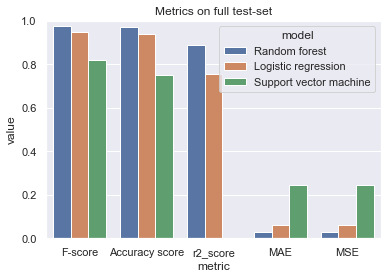

In [29]:
baseline_evaluations_tidy = (
    baseline_evaluations
    .drop(["Class accuracies","Confusion matrix"],axis=1)
    .reset_index()
    .rename({"index": "model"}, axis=1)
    .melt(id_vars=["model"], var_name="metric")
)
sns.barplot(data=baseline_evaluations_tidy, x="metric", y="value", hue="model")
plt.ylim(0, 1)
plt.title("Metrics on full test-set")

Clearly, the random forest shows the best performance with 97.6% test accuracy. In contrast, the support vector machine performs the worst with only 82.1%.

# Construct neural network

Let us try to beat the above scores using a neural network. We consider a simple feedforward neural network with the following specifications:

* 3 hidden layers of constant size given by 32

* Adam optimiser

* sigmoid activation

* loss function given by means-squared-error

In [30]:
ndim=len(X[0]) #dimension of input features
activiation='sigmoid' 

def build_model():
    layer_size=32
    model = keras.Sequential([
    layers.Dense(layer_size, activation=activiation, input_shape=[ndim]),
    layers.Dense(layer_size,activation=activiation),
    layers.Dense(layer_size,activation=activiation),
    layers.Dense(layer_size,activation=activiation),
    layers.Dense(1)# Output 0 or 1
      ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

model=build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1440      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


For training, we use the following parameters:
* batch size of 10
* validation split 10%

In [31]:
EPOCHS=200
batch_size=10

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

early_history = model.fit(train_data, train_label, 
                    epochs=EPOCHS,validation_split = 0.1,batch_size=batch_size,verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1948,  mae:0.3845,  mse:0.1948,  val_loss:0.0586,  val_mae:0.1386,  val_mse:0.0586,  
....................................................................................................
Epoch: 100, loss:0.0042,  mae:0.0211,  mse:0.0042,  val_loss:0.0124,  val_mae:0.0370,  val_mse:0.0124,  
....................................................................................................

Text(0, 0.5, 'MAE')

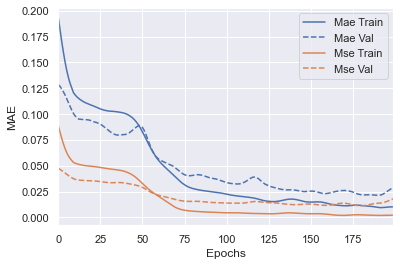

In [32]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'MAE': early_history}, metric = "mae")
plotter.plot({'MSE': early_history}, metric = "mse")
#plt.ylim([0, 6])
plt.ylabel('MAE')

In [33]:
#Due to the construction of the NN, we have to round our values for a classification problem
test_predictions=np.round(model.predict(test_data)).astype(int)
#If negative values appear, teplace all -1 by 0
test_predictions[test_predictions==-1]=0

baseline_evaluations_NN = pd.DataFrame({
    metric_name: {
        "Neural Network": metric(test_label, test_predictions)
    }
    for metric_name, metric in metrics.items()
})
cm=baseline_evaluations_NN["Class accuracies"].to_list()
cm_new=[]
for mod in cm:
    mod=np.round((mod / mod.sum(axis=1)[:, np.newaxis]).diagonal(),6)
    cm_new.append(mod)
    
baseline_evaluations_NN["Class accuracies"]=cm_new
baseline_evaluations_NN["Confusion matrix"]=cm
baseline_evaluations=baseline_evaluations.append(baseline_evaluations_NN)
baseline_evaluations

,F-score,Accuracy score,Class accuracies,r2_score,MAE,MSE,Confusion matrix
Random forest,0.976152,0.972619,"[0.955236, 0.985816]",0.888383,0.027381,0.027381,"[[2454, 115], [48, 3336]]"
Logistic regression,0.949653,0.940366,"[0.875827, 0.989362]",0.756908,0.059634,0.059634,"[[2250, 319], [36, 3348]]"
Support vector machine,0.821198,0.752898,"[0.429739, 0.998227]",-0.007289,0.247102,0.247102,"[[1104, 1465], [6, 3378]]"
Neural Network,0.991309,0.990089,"[0.98443, 0.994385]",0.959599,0.009911,0.009911,"[[2529, 40], [19, 3365]]"


Text(0.5, 1.0, 'Metrics on full test-set')

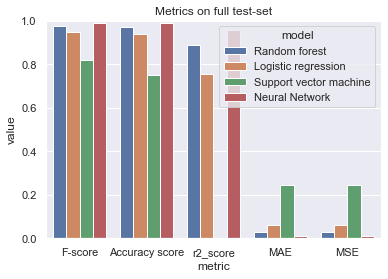

In [34]:
baseline_evaluations_tidy = (
    baseline_evaluations
    .drop(["Class accuracies","Confusion matrix"],axis=1)
    .reset_index()
    .rename({"index": "model"}, axis=1)
    .melt(id_vars=["model"], var_name="metric")
)
sns.barplot(data=baseline_evaluations_tidy, x="metric", y="value", hue="model")
plt.ylim(0, 1)
plt.title("Metrics on full test-set")

The NN outperforms the random forest model leading to an overall accuracy of 99.1%. Notice that there is a slight imbalance in the off-diagonal elements of the confusion matrix for the NN. In fact, there are more *false positive* classifications. These issues should hopefully be resolved by e.g. including permutations in the input vectors.

The above approach to understanding conservation laws in particle decays is indeed very promising. In the future, we would like to extend our model is several directions:

1.) Predicting new particles

2.) Searching for hidden symmetries

3.) Predicting decay rates